In [9]:
import CompDoobTransform as cdt
import time
from CompDoobTransform import core
import math
import torch
import matplotlib.pyplot as plt
from CompDoobTransform.utils import normal_logpdf, resampling
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Computing on ' + str(device))

Computing on cpu


In [2]:
# tuning parameters 
d = 1
# std_obs = 0.125
std_obs = 1.0
filename = 'OU_var_obs_small.pt'

In [10]:
# dict for objects relating to latent state process
state = {}

# dimension of state 
state['dim'] = d

# drift of diffusion
beta = torch.tensor(1.0, device = device) 
b = lambda x: - beta * x # drift
state['drift'] = b

# diffusion coefficient of diffusion
sigma = torch.tensor(1.0, device = device) # diffusion coefficient
state['sigma'] = sigma

# simulate initial states (from stationary distribution)
initial = lambda N: (sigma / torch.sqrt(2.0 * beta)) * torch.randn(N, d, device = device)
state['initial'] = initial

# time interval
T = torch.tensor(1.0, device = device) 
state['terminal_time'] = T

In [11]:
# dict for objects relating to observations
obs = {}

# dimension of observation
p = d
obs['dim'] = p

# observation parameters
var_obs = torch.tensor(std_obs**2, device = device) # variance of observation

# log-observation density
obs_log_density = lambda x, y: normal_logpdf(y, x, var_obs) # terminal condition, returns size (N)
obs['log_density'] = obs_log_density

# simulate observations
observation = lambda N: initial(N) + torch.sqrt(var_obs) * torch.randn(N, p, device = device)
obs['observation'] = observation

In [12]:
# define standardization means and standard deviations
standardization = {'x_mean': torch.zeros(1), 
                   'x_std': (sigma / torch.sqrt(2.0 * beta)) * torch.ones(1), 
                   'y_mean': torch.zeros(1), 
                   'y_std': torch.sqrt(sigma**2 / (2.0 * beta) + var_obs) * torch.ones(1)}

standardization

{'x_mean': tensor([0.]),
 'x_std': tensor([0.7071]),
 'y_mean': tensor([0.]),
 'y_std': tensor([1.2247])}

In [13]:
# transition mean and variance 
mean_x = lambda t,x: x * torch.exp(- beta * t)
var_x = lambda t: (1.0 - torch.exp(- 2.0 * beta * t)) / (2 * beta)

# posterior mean and variance at time T
var_h = lambda t: 1.0 / (1.0 / var_x(t) + 1.0 / var_obs)
mean_h = lambda x0,y: var_h(T) * (mean_x(T, x0) / var_x(T) + y / var_obs)

# h function
def log_h(t,x,y): 
    if t < T:
        output = - 0.5 * d * torch.log(torch.tensor(2 * math.pi, device = device)) \
                 - 0.5 * d * torch.log(var_x(T-t)) - 0.5 * d * torch.log(var_obs) + 0.5 * d * torch.log(var_h(T-t)) \
                 + 0.5 * var_h(T-t) * torch.sum(torch.square(mean_x(T-t,x) / var_x(T-t) + y / var_obs), dim = 1, keepdim = True) \
                 - 0.5 * torch.sum(torch.square(mean_x(T-t,x)), dim = 1, keepdim = True) / var_x(T-t) \
                 - 0.5 * torch.sum(torch.square(y)) / var_obs
    else: 
        output = obs_log_density(x,y)
    return output

# true V0 network
V0_net_true = lambda x,y: -log_h(0.0, x, y.reshape(1,p)).squeeze()

# true Z network 
Z_net_true = lambda t,x,y: - var_h(T-t) * (mean_x(T-t,x) / var_x(T-t) + y / var_obs) * torch.exp(- beta * (T-t)) / var_x(T-t) \
                           + mean_x(T-t,x) * torch.exp(- beta * (T-t)) / var_x(T-t)

In [14]:
# time-discretization settings
M = 50 # number of time steps

# V0 and Z neural network configuration
V0_net_config = {'layers': [16], 'standardization': standardization}
Z_net_config = {'layers': [d+16], 'standardization': standardization}
net_config = {'V0': V0_net_config, 'Z': Z_net_config}

# learning type
# learning_type = 'standard'
learning_type = 'iterative'                

# create model instance
model = core.model(state, obs, M, net_config, device = 'cpu')

In [15]:
# optimization configuration (standard training)
I = 2000
optim_config = { 'minibatch': 100,
                'num_obs_per_batch': 10, 
                'num_iterations': I,
                'learning_rate' : 0.01, 
                'initial_required' : True}
# training
time_start = time.time() 
if learning_type == 'standard':
    model.train_standard(optim_config)
if learning_type == 'iterative':
    model.train_iterative(optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

Optimization iteration: 1 Loss: 14.279099464416504
Optimization iteration: 50 Loss: 1.4167462587356567
Optimization iteration: 100 Loss: 0.4872007369995117
Optimization iteration: 150 Loss: 0.1628858894109726
Optimization iteration: 200 Loss: 0.4969482719898224
Optimization iteration: 250 Loss: 0.41600513458251953
Optimization iteration: 300 Loss: 0.08625026047229767
Optimization iteration: 350 Loss: 0.1615932732820511
Optimization iteration: 400 Loss: 0.06137062981724739
Optimization iteration: 450 Loss: 0.06966377049684525
Optimization iteration: 500 Loss: 0.07645837217569351
Optimization iteration: 550 Loss: 0.03397888317704201
Optimization iteration: 600 Loss: 0.05112680420279503
Optimization iteration: 650 Loss: 0.0210377499461174
Optimization iteration: 700 Loss: 0.028487535193562508
Optimization iteration: 750 Loss: 0.04781825840473175
Optimization iteration: 800 Loss: 0.03139648586511612
Optimization iteration: 850 Loss: 0.07271594554185867
Optimization iteration: 900 Loss: 0.0

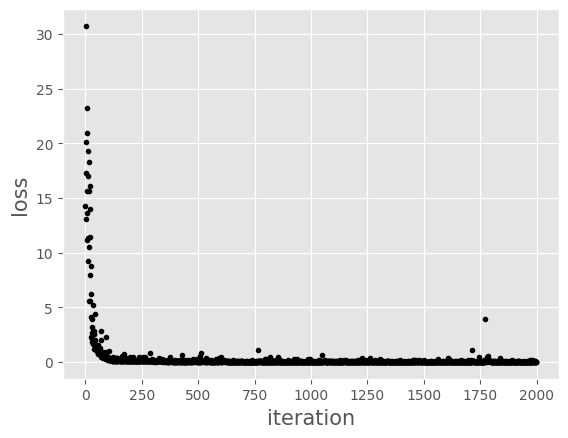

In [16]:
# plot loss over optimization iterations
plt.figure()
plt.plot(torch.arange(I), model.loss.to('cpu'), 'k.')
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.show()

In [17]:
# auxiliary particle filter with true networks
def run_true_APF(initial_states, observations, num_samples):
    """
    Run auxiliary particle filter with true networks.
    
    Parameters
    ----------
    initial_states : initial states of X process (N, d)
    
    observations : sequence of observations to be filtered (K, p)

    num_samples : sample size (int)

    Returns
    -------
    dict containing:    
        states : X process at observation times (N, K+1, d) or (N, K*M+1, d) if full_path == True
        ess : effective sample sizes at unit times (K+1)        
        log_norm_const : log-normalizing constant estimates (K+1)
    """
    
    # initialize and preallocate
    N = num_samples
    Y = observations
    K = observations.shape[0]        
    X = initial_states        
    states = torch.zeros(N, K+1, d, device = device)
    states[:, 0, :] = X
    ess = torch.zeros(K+1, device = device)
    ess[0] = N
    log_norm_const = torch.zeros(K+1, device = device)
    log_ratio_norm_const = torch.tensor(0.0, device = device)
    
    # each observation
    for k in range(K):        

        # evaluate initial values V0
        V0 = V0_net_true(X, Y[k,:]) # size (N)            
        V = V0.clone()
        
        # each time interval
        for m in range(M):
            # time step 
            stepsize = model.stepsizes[m]
            t = model.time[m]

            # Brownian increment
            W = torch.sqrt(stepsize) * torch.randn(N, d, device = device) # size (N, d)
            
            # simulate V process forwards in time            
            Z = Z_net_true(t, X, Y[k,:]) # size (N, d)
            control = - Z.clone()
            drift_V = - 0.5 * torch.sum(torch.square(Z), 1) # size (N)                
            euler_V = V + stepsize * drift_V # size (N)
            V = euler_V + torch.sum(Z * W, 1) # size (N)

            # simulate X process forwards in time
            drift_X = b(X) + sigma * control
            euler_X = X + stepsize * drift_X
            X = euler_X + sigma * W

        # compute and normalize weights, compute ESS and normalizing constant
        log_weights = V + obs_log_density(X, Y[k,:]) - V0
        max_log_weights = torch.max(log_weights)
        weights = torch.exp(log_weights - max_log_weights)
        normalized_weights = weights / torch.sum(weights)
        ess[k+1] = 1.0 / torch.sum(normalized_weights**2)
        log_ratio_norm_const = log_ratio_norm_const + torch.log(torch.mean(weights)) + max_log_weights
        log_norm_const[k+1] = log_ratio_norm_const

        # resampling            
        ancestors = resampling(normalized_weights, N)
        X = X[ancestors,:]

        # store states 
        states[:, k+1, :] = X

    # output
    output = {'states' : states, 'ess' : ess, 'log_norm_const' : log_norm_const}

    return output


In [18]:
# fully adapted auxiliary particle filter without time-discretization
def run_FA_APF(initial_states, observations, num_samples):
    """
    Run fully adapted auxiliary particle filter.
    
    Parameters
    ----------
    initial_states : initial states of X process (N, d)
    
    observations : sequence of observations to be filtered (K, p)

    num_samples : sample size (int)

    Returns
    -------
    dict containing:    
        states : X process at observation times (N, K+1, d) or (N, K*M+1, d) if full_path == True
        ess : effective sample sizes at unit times (K+1)        
        log_norm_const : log-normalizing constant estimates (K+1)
    """
    
    # initialize and preallocate
    N = num_samples
    Y = observations
    K = observations.shape[0]        
    X = initial_states        
    states = torch.zeros(N, K+1, d, device = device)
    states[:, 0, :] = X
    ess = torch.zeros(K+1, device = device)
    ess[0] = N
    log_norm_const = torch.zeros(K+1, device = device)
    log_ratio_norm_const = torch.tensor(0.0, device = device)
    
    # each observation
    for k in range(K): 
        # compute and normalize weights, compute ESS and normalizing constant
        log_weights = log_h(0.0, X, Y[k,:].reshape(1,p)).squeeze()
        max_log_weights = torch.max(log_weights)
        weights = torch.exp(log_weights - max_log_weights)
        normalized_weights = weights / torch.sum(weights)
        ess[k+1] = 1.0 / torch.sum(normalized_weights**2)
        log_ratio_norm_const = log_ratio_norm_const + torch.log(torch.mean(weights)) + max_log_weights
        log_norm_const[k+1] = log_ratio_norm_const

        # resampling            
        ancestors = resampling(normalized_weights, N)
        X = X[ancestors,:]

        # move using locally optimal proposal transition
        X = mean_h(X, Y[k,:].reshape(1,p)) + torch.sqrt(var_h(T)) * torch.randn(N, d, device = device)

        # store states 
        states[:, k+1, :] = X

    # output
    output = {'states' : states, 'ess' : ess, 'log_norm_const' : log_norm_const}

    return output

In [19]:
# optimally guided intermediate resampling filter
def guiding_initial(x,y):
    y = y.reshape(1,p)
    guiding = log_h(0.0, x, y).squeeze()
    return guiding

def guiding_intermediate(m, x, x_next, y):
    t = float(model.time[m-1])
    t_next = float(model.time[m])
    y = y.reshape(1,p)
    log_potential = log_h(t, x, y).squeeze()
    log_potential_next = log_h(t_next, x_next, y).squeeze()
    guiding = log_potential_next - log_potential
    return guiding

def guiding_obs_time(m, x, x_next, y, y_next):
    guiding = guiding_intermediate(m, x, x_next, y) + guiding_initial(x_next,y_next)
    return guiding

guiding_function = {'initial': guiding_initial, 
                    'intermediate': guiding_intermediate,
                    'obs_time': guiding_obs_time}


In [20]:
# repeat particle filters
multiplier = 1.0
num_obs = [100, 200, 400, 800, 1600]
len_num_obs = len(num_obs)
num_particles = [2**6, 2**7, 2**8, 2**9, 2**10]
R = 100 # number of repeats
BPF = {'ess' : torch.zeros(len_num_obs, R), 'log_estimate' : torch.zeros(len_num_obs, R)}
APF = {'ess' : torch.zeros(len_num_obs, R), 'log_estimate' : torch.zeros(len_num_obs, R)}
true_APF = {'ess' : torch.zeros(len_num_obs, R), 'log_estimate' : torch.zeros(len_num_obs, R)}
FA_APF = {'ess' : torch.zeros(len_num_obs, R), 'log_estimate' : torch.zeros(len_num_obs, R)}
GIRF = {'ess' : torch.zeros(len_num_obs, R), 'log_estimate' : torch.zeros(len_num_obs, R)}

for i in range(len_num_obs):
    # number of observations
    K = num_obs[i]

    # number of particles
    N = num_particles[i]

    # simulate latent process and observations
    X0 = initial(1)
    X = torch.zeros(K+1, d)
    X[0,:] = X0.clone()
    Y = torch.zeros(K, p)
    for k in range(K):
        X[k+1,:] = model.simulate_diffusion(X[k,:])
        Y[k,:] = X[k+1,:] + multiplier * torch.sqrt(var_obs) * torch.randn(1,p)

    for r in range(R):
        # run particle filters
        BPF_output = model.run_BPF(X0.repeat((N,1)), Y, N)
        APF_output = model.run_APF(X0.repeat((N,1)), Y, N)
        true_APF_output = run_true_APF(X0.repeat((N,1)), Y, N)
        FA_APF_output = run_FA_APF(X0.repeat((N,1)), Y, N)
        GIRF_output = model.run_GIRF(X0.repeat((N,1)), Y, N, guiding_function)

        # save average ESS%
        BPF_ESS = torch.mean(BPF_output['ess'] * 100 / N)
        APF_ESS = torch.mean(APF_output['ess'] * 100 / N)
        true_APF_ESS = torch.mean(true_APF_output['ess'] * 100 / N)
        FA_APF_ESS = torch.mean(FA_APF_output['ess'] * 100 / N)
        GIRF_ESS = torch.mean(GIRF_output['ess'] * 100 / N)
        BPF['ess'][i,r] = BPF_ESS
        APF['ess'][i,r] = APF_ESS
        true_APF['ess'][i,r] = true_APF_ESS
        FA_APF['ess'][i,r] = FA_APF_ESS
        GIRF['ess'][i,r] = GIRF_ESS

        # save log-likelihood estimates
        BPF_log_estimate = BPF_output['log_norm_const'][-1]
        APF_log_estimate = APF_output['log_norm_const'][-1]
        true_APF_log_estimate = true_APF_output['log_norm_const'][-1]
        FA_APF_log_estimate = FA_APF_output['log_norm_const'][-1]
        GIRF_log_estimate = GIRF_output['log_norm_const'][-1]
        BPF['log_estimate'][i,r] = BPF_log_estimate
        APF['log_estimate'][i,r] = APF_log_estimate
        true_APF['log_estimate'][i,r] = true_APF_log_estimate
        FA_APF['log_estimate'][i,r] = FA_APF_log_estimate
        GIRF['log_estimate'][i,r] = GIRF_log_estimate

        # print output
        print('No. of observations: ' + str(K) + ' Repeat: ' + str(r)) 
        print('BPF ESS%: ' + str(BPF_ESS))
        print('APF ESS%: ' + str(APF_ESS)) 
        print('True-APF ESS%: ' + str(true_APF_ESS)) 
        print('FA-APF ESS%: ' + str(FA_APF_ESS)) 
        print('GIRF ESS%: ' + str(GIRF_ESS)) 
        print('BPF log-estimate: ' + str(BPF_log_estimate))
        print('APF log-estimate: ' + str(APF_log_estimate))
        print('True-APF log-estimate: ' + str(true_APF_log_estimate))
        print('FA-APF log-estimate: ' + str(FA_APF_log_estimate))
        print('GIRF log-estimate: ' + str(GIRF_log_estimate))

# save results
results = {'BPF' : BPF, 'APF' : APF, 'True-APF' : true_APF , 'FA-APF' : FA_APF, 'GIRF' : GIRF}
torch.save(results, filename)

No. of observations: 100 Repeat: 0
BPF ESS%: tensor(57.7322)
APF ESS%: tensor(93.3514)
True-APF ESS%: tensor(93.7696)
FA-APF ESS%: tensor(94.0038)
GIRF ESS%: tensor(98.3489)
BPF log-estimate: tensor(-339.7862)
APF log-estimate: tensor(-339.0021)
True-APF log-estimate: tensor(-338.1318)
FA-APF log-estimate: tensor(-338.4633)
GIRF log-estimate: tensor(-336.4582)
No. of observations: 100 Repeat: 1
BPF ESS%: tensor(57.6876)
APF ESS%: tensor(93.5563)
True-APF ESS%: tensor(93.6803)
FA-APF ESS%: tensor(93.7140)
GIRF ESS%: tensor(98.2192)
BPF log-estimate: tensor(-339.2985)
APF log-estimate: tensor(-338.0582)
True-APF log-estimate: tensor(-339.1023)
FA-APF log-estimate: tensor(-339.0965)
GIRF log-estimate: tensor(-341.3683)
No. of observations: 100 Repeat: 2
BPF ESS%: tensor(58.2353)
APF ESS%: tensor(93.4157)
True-APF ESS%: tensor(93.9493)
FA-APF ESS%: tensor(93.7910)
GIRF ESS%: tensor(98.2861)
BPF log-estimate: tensor(-341.1717)
APF log-estimate: tensor(-338.5486)
True-APF log-estimate: tenso

KeyboardInterrupt: 